# Course 6: Time series project

### Student: Peter Jones
### Date started: 2018.04.30

## Step 1: Plan the analysis

### 1.	Does the dataset meet the criteria of a time series dataset? Make sure to explore all four key characteristics of a time series data.

In [1]:
library( readxl )
library( lubridate )
library( forecast )
library( TTR )


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Warning message:
“package ‘forecast’ was built under R version 3.4.4”

In [2]:
df <- read_excel('../data/6_ts/monthly-sales.xlsx')

In [3]:
head( df )

Month,Monthly Sales
2008-01,154000
2008-02,96000
2008-03,73000
2008-04,51000
2008-05,53000
2008-06,59000


In [4]:
df.ts <- ts( df[,2], start = c( 2008, 1), frequency = 12 )

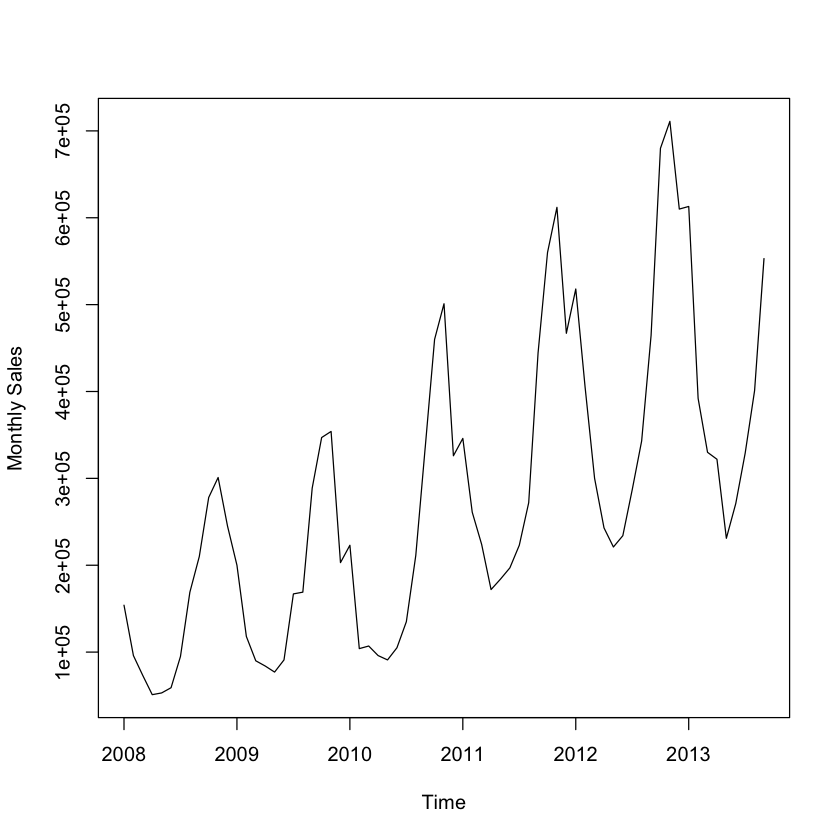

In [5]:
plot.ts( df.ts )

From the time series plot above, these data appear to have time series components:
- Equal spacing between each time point
- Covers a continuous time period
- Each time point has one measurement
- There are sequential measurements across each interval

### 2.	Which records should be used as the holdout sample?

The instructions specify that the 4 most recent periods should be held out as the validation sample, so I've held out June 2016 through September 2016.

In [6]:
df.ts.test <- window( df.ts, start = c(2008,1), end = c(2013,5))

In [7]:
df.ts.val <- window( df.ts, start = c( 2013,6), end = c(2013,9))

## Step 2: Determine trend, seasonal, and error components

### 1.	What are the trend, seasonality, and error of the time series? Show how you were able to determine the components using time series plots. Include the graphs.

In [8]:
df.ts.decomp <- decompose( df.ts )

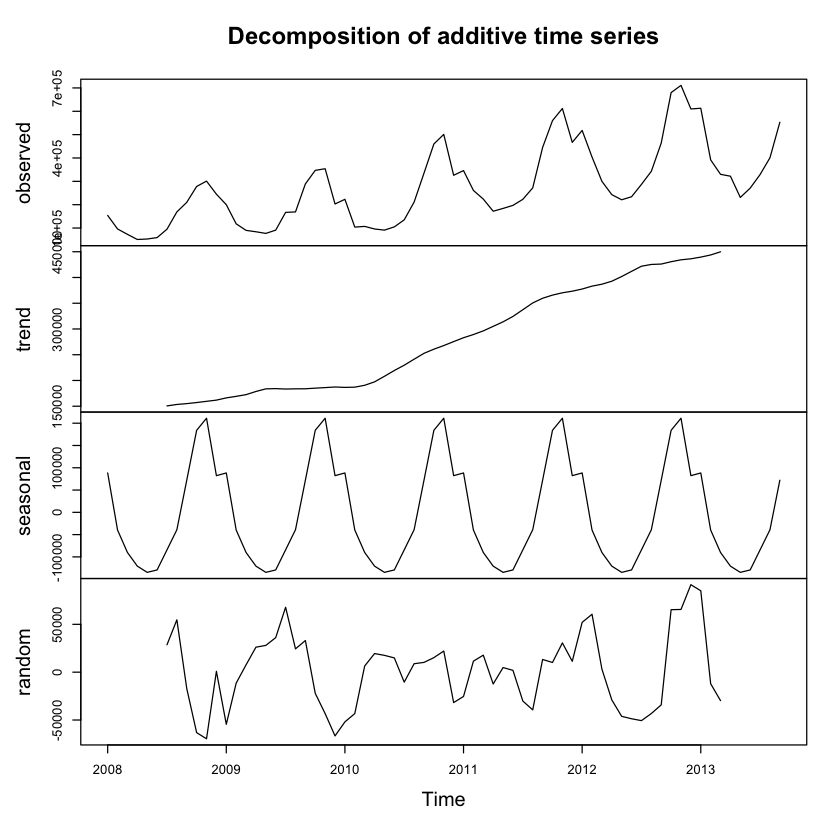

In [9]:
plot( df.ts.decomp )

From the decomposition plot above, I determined the following characteristics:
- There is an approximately additive trend in these data.
- There is a slightly multiplicative seasonal component.
- The errors are roughly normal, with fairly stable stationarity.

## Step 3: Build the models

### 1.	What are the model terms for ETS? Explain why you chose those terms.

From the decomposition plots, there are additive trend and multiplicative seasonal components for these data, suggesting that we use the Holt-Winters ETS method.
- The errors are roughly normal, suggesting a multiplicative term for errors.
- The trend plot shows an initial flat period, but overall shows a constant upward trend, suggesting an additive trend term.
- The seasonality plot shows a slightly increasing seasonal effect, suggesting an multiplicative seasonal term.

In [10]:
fit.mam <- ets( df.ts.test, model = "MAM" )

In [11]:
fit.mam

ETS(M,Ad,M) 

Call:
 ets(y = df.ts.test, model = "MAM") 

  Smoothing parameters:
    alpha = 0.8606 
    beta  = 0.0131 
    gamma = 1e-04 
    phi   = 0.98 

  Initial states:
    l = 108789.245 
    b = 6554.3803 
    s=1.2681 1.764 1.695 1.3316 0.9107 0.7049
           0.5312 0.5009 0.5551 0.6649 0.8161 1.2574

  sigma:  0.1505

     AIC     AICc      BIC 
1640.123 1654.993 1679.262 

In [12]:
accuracy( fit.mam )

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,3243.47,31474.37,24188.22,-0.572395,10.3052,0.3528697,0.008740233


The root mean squared error (RMSE) is 31,474.37 and the mean average squared error (MASE) is 0.353, suggesting that we have decent model accuracy.

### 2.	What are the model terms for ARIMA? Explain why you chose those terms. Graph the Auto-Correlation Function (ACF) and Partial Autocorrelation Function Plots (PACF) for the time series and seasonal component and use these graphs to justify choosing your model terms.

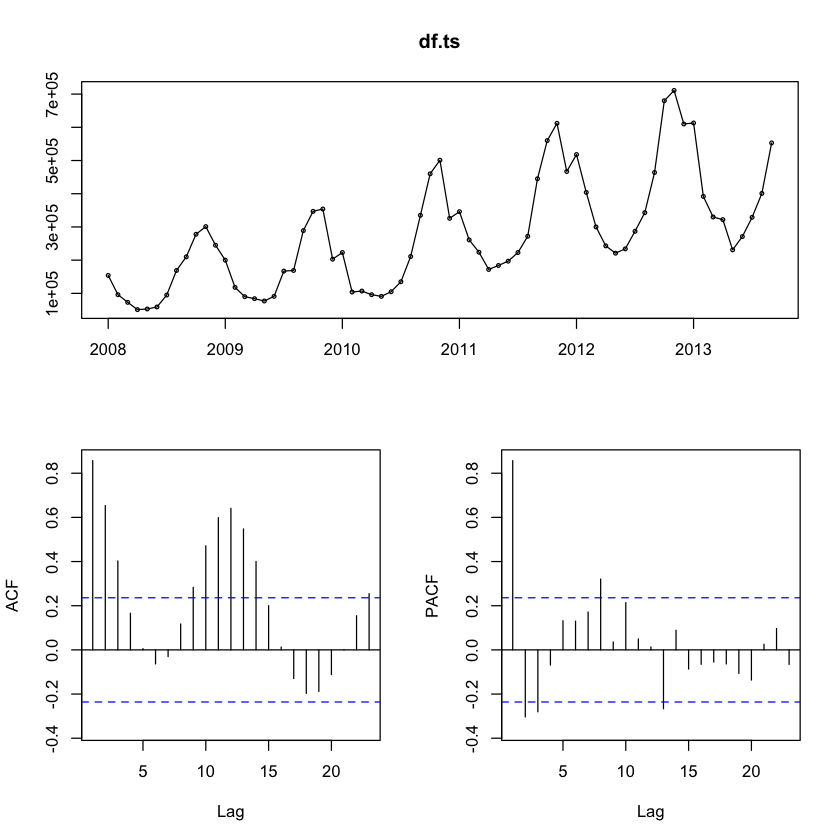

In [13]:
tsdisplay( df.ts )

We don't have stationarity in these data, so I will take the seasonal difference.

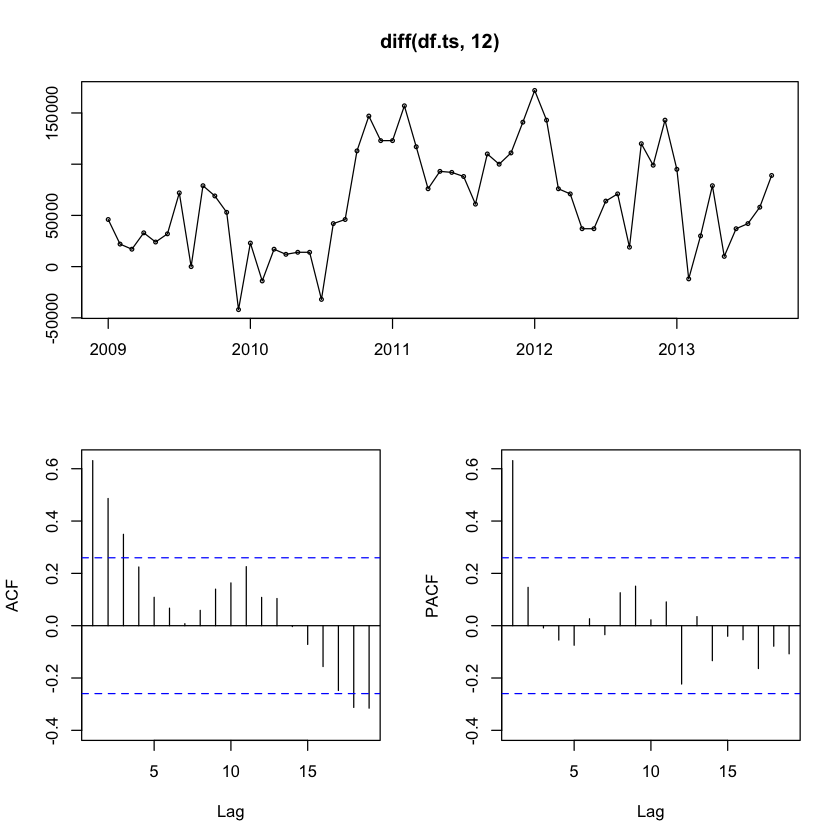

In [14]:
tsdisplay( diff( df.ts, 12 ) )

We've not acheived stationarity, but the seasonal component is addressed. Taking the first difference now.

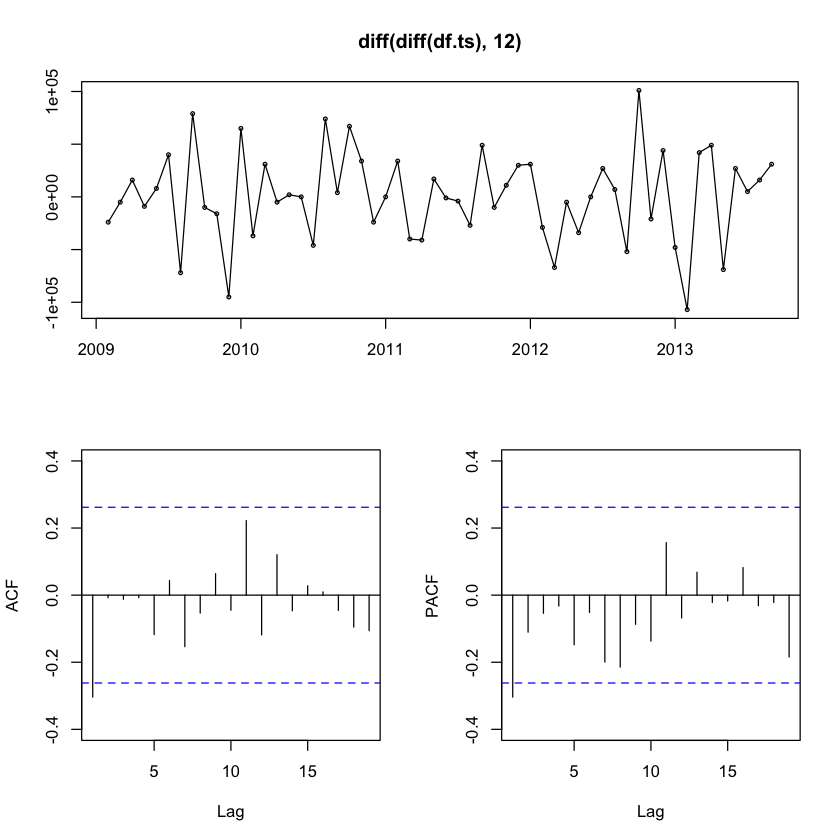

In [15]:
tsdisplay( diff( diff( df.ts ), 12 ) )

Now it looks like we've acheived stationarity but for lag 1. The negative value at lag 1 for both ACF and PACF plots suggests adding an MA term.

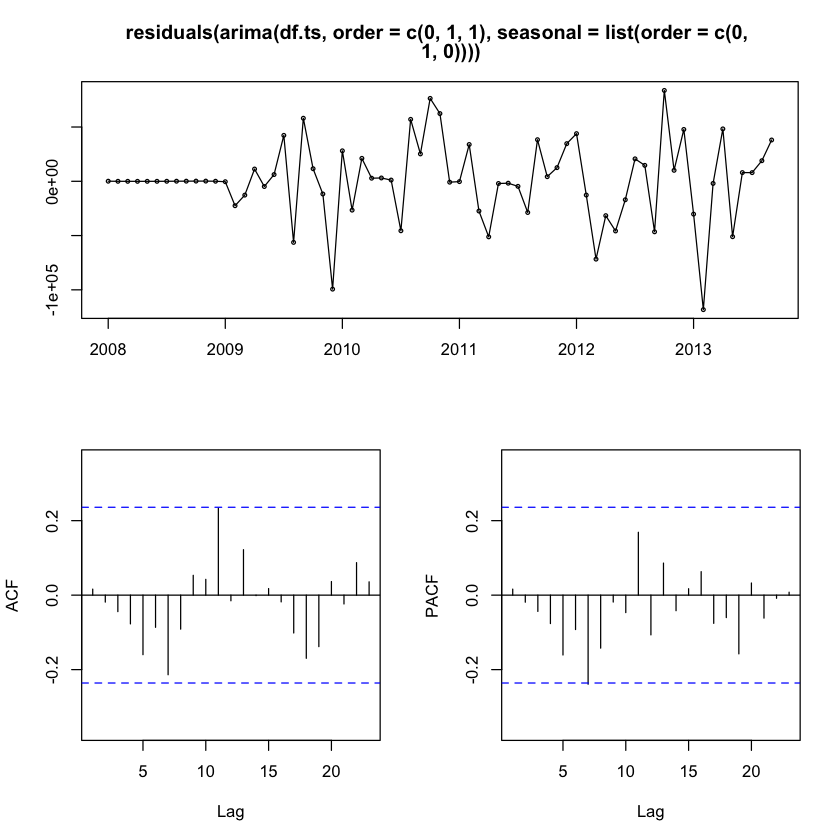

In [16]:
tsdisplay( residuals( arima( df.ts, order = c(0,1,1), seasonal = list( order = c(0,1,0) ) ) ) )

Adding the MA terms brings us to stationarity.
The terms I would choose for this model include:
- No term for the auto-regressive component given the negative ACF and PACF for lag one of the non-seasonal
- One integration term to improve stationarity
- No non-seasonal moving average term 
- One term for the auto-regressive component given the positive ACF and PACF for lag twelve
- A single seasonal integration term to improve stationarity
- No seasonal moving average term given the positive ACF and PACF values at lag 1

In [17]:
fit.arima <- arima( df.ts.test, order = c(0,1,1), seasonal = list(order = c(0,1,0) ) )

#### a.	Describe the in-sample errors. Use at least RMSE and MASE when examining results

In [18]:
accuracy( fit.arima )

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-356.2665,36761.53,24993.04,-1.802137,9.824411,0.4153609,0.01641446


The in-sample RMSE is 36,761.53 and the MASE is 0.415, which is well below the accepted threshold of 1.0 for model accuracy.

#### b.	Regraph ACF and PACF for both the Time Series and Seasonal Difference and include these graphs in your answer.

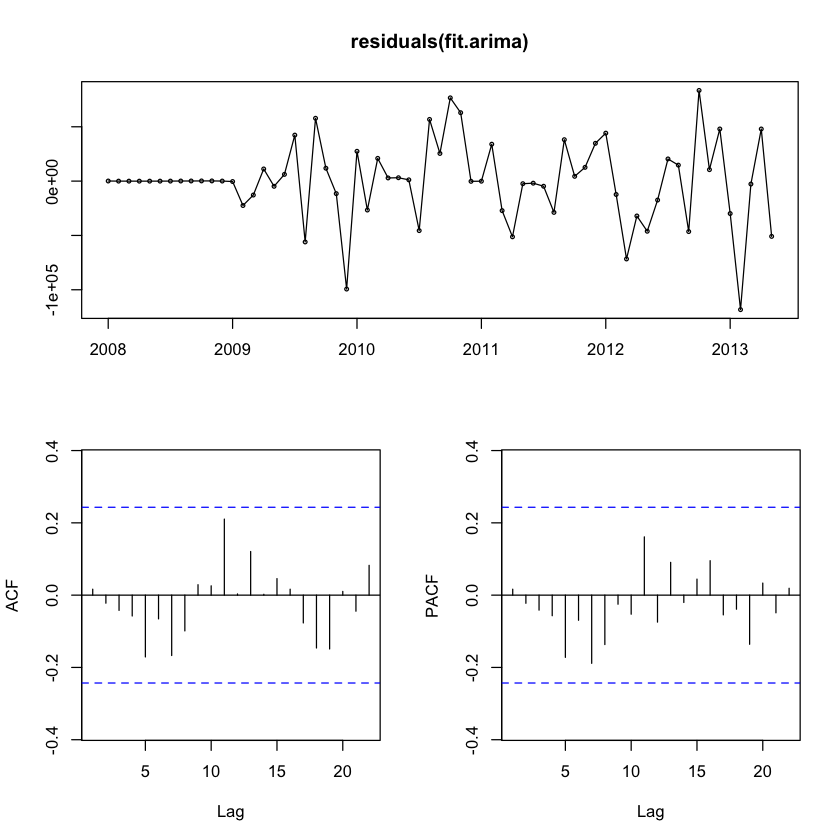

In [19]:
tsdisplay( residuals( fit.arima ) )

## Step 4: Forecast

### Compare the in-sample error measurements to both models and compare error measurements for the holdout sample in your forecast. Choose the best fitting model and forecast the next four periods.

In [20]:
accuracy( fit.mam )

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,3243.47,31474.37,24188.22,-0.572395,10.3052,0.3528697,0.008740233


In [21]:
accuracy( fit.arima )

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-356.2665,36761.53,24993.04,-1.802137,9.824411,0.4153609,0.01641446


In [22]:
accuracy( forecast( fit.mam, 4 ), df.ts.val )

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,3243.47,31474.37,24188.22,-0.572395,10.305204,0.3528697,0.008740233,NA
Test set,-33469.61,53828.48,41542.76,-6.347585,9.326605,0.6060462,0.200844270,0.5678561


In [23]:
accuracy( forecast( fit.arima, 4 ), df.ts.val )

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-356.2665,36761.53,24993.04,-1.802137,9.824411,0.3646109,0.01641446,NA
Test set,27271.5199,33999.79,27271.52,6.183294,6.183294,0.3978504,0.18784112,0.3676543


### 1.	Which model did you choose? Justify your answer by showing: in-sample error measurements and forecast error measurements against the holdout sample.
While initially the ETS model seemed to perform better with lower RMSE and MASE values, against the validation set the ARIMA model performed better as measured by the same two diagnostic values.
I would choose the ARIMA(0,1,1)(0,1,0)[12] model for this prediction.

### 2.	What is the forecast for the next four periods? Graph the results using 95% and 80% confidence intervals

In [24]:
fit.full.arima <- arima( df.ts, order = c(0,1,1), seasonal = list( order = c(0,1,0) ) )

In [25]:
forecast( fit.full.arima, 4 )

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2013       754854.5 703538.2 806170.7 676373.1 833335.9
Nov 2013       785854.5 725251.4 846457.5 693170.1 878538.8
Dec 2013       684854.5 616209.7 753499.2 579871.3 789837.6
Jan 2014       687854.5 612015.9 763693.0 571869.5 803839.5

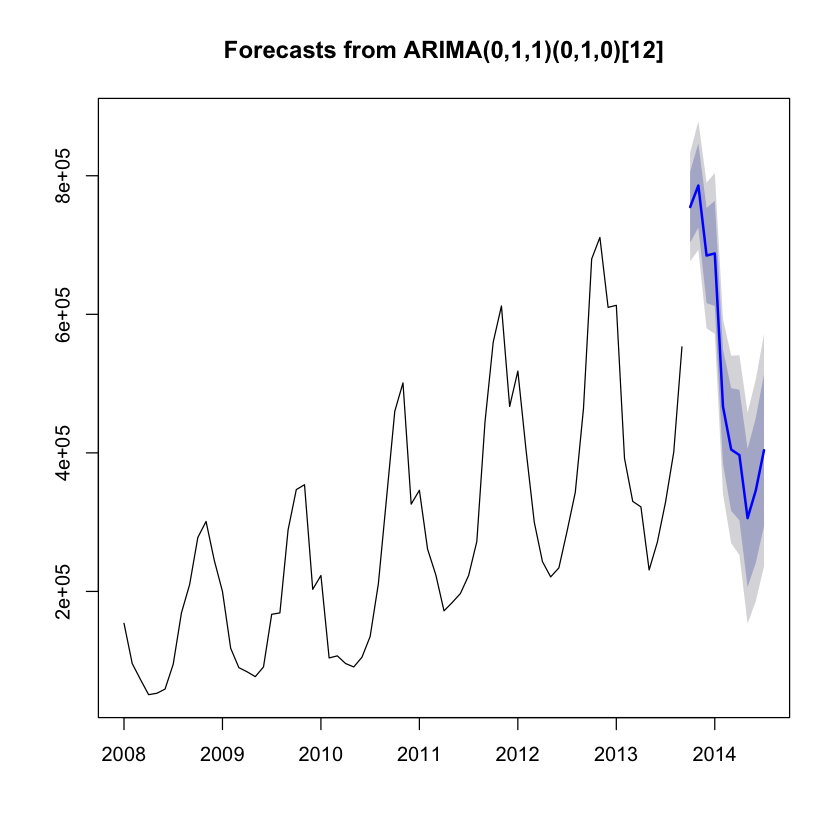

In [26]:
plot( forecast( fit.full.arima, 10 ) )